In [4]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
import sklearn
from sklearn.linear_model import SGDRegressor

# Pyradiomics model

# Table of Contents
1. [Feature extraction](#feature-extraction)
2. [Feature selection](#feature-selection)
3. [Model 1: Linear Support Vector Classifier](#model1)
4. [Model 2: Stochastic Gradient Descent Regressor](#model2)


## 1. <a id='feature-extraction'>Feature extraction</a>

Code for feature extraction using pyradiomics and dependencies: dcm2niix and SimpleITK. We built a docker image for running the pyradiomics-dcm.py script that is available on the pyradiomics github under labs. The script was still experimental and outdated so we had to make adjustments in the script and dockerfile to make it run. If you want to install the docker container yourself we can provide the working dockerfile. 
The Feature extraction uses the pylidc library and to channel directories and read out the corresponding segmentation and icom files for each patient. These then get passed to the pyradiomics docker container with the experimental script for evaluation. 
The result is a vector with 1574 features. These are put together with metadata and saved inside a csv file.

In [5]:
#Function that calculates features using the pyradiomics-dcm.py script from the pyradiomics GIT
def get_features():
    ###################### put the working directories here ###################################
    start_time = time.time()
    # put path of dataset here
    parent_dir = r"/Images+seg/manifest-1698768984202"
    patient_dicom_path_mounted = r"/data/Images+seg/manifest-1698768984202/LIDC-IDRI"
    # get path of LIDC-IDRI directionary
    data_dir = os.path.join(parent_dir, "LIDC-IDRI")
    # give directory where docker saves files
    docker_save_dir = r"/"
    # give the hash of the pyradiomnics docker
    docker_hash = r"d95ce08239e3182d8631d3492a5e4a32096d28285c3d2f10dd570d7e6d06fd01"
    # path to the features dict
    features_dict = r"/data/test/featuresDict_IBSIv7.tsv"
    # pyradiomics save folder
    pyradiomics_midsave_path = r"/data/pyradiomics converter test"
    # temporal dir
    temp_dir = r"/test/temp file"
    parameter_file = r"/test/Pyradiomics_Params_test.yaml"
    ########################################################################################
    # create dataframes for data storage
    data = pd.read_csv(r"/test/features.csv")
    data = data.drop(0, axis=0)
    df = pd.read_excel(r"C:\Users\Diederik\OneDrive\Bureaublad\studie tn\Minor vakken Porto\IA CAD\test\nodule_counts_by_patient.xlsx")
    df = df.drop(df.columns[[4, 5]], axis=1)
    df.columns = ['Patient_ID', 'Total_Nodule_Count', 'NodG3','NodL3']
    dataframe = pd.DataFrame(
        columns=['Patient_ID', 'Nodule', ' Annotation', 'Subtlety', 'InternalStructure', 'Calcification', 'Sphericity',
                 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy'])
    iteration_counter = 1


# We process each patient chronologically
    for p_id in df['Patient_ID']:

        print("Patient " + str(p_id) + "Processing")
        if os.path.isdir(os.path.join(data_dir, str(p_id))) == False:
            print("Patient " + str(p_id) + " not found")
            continue  # if the patient folder doesn't exist, skip it

        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == p_id).first()
        nods = scan.cluster_annotations()

        if scan is None:  # if the scan is not available, continue
            continue

        # path to the patient folder
        patient_dir = os.path.join(data_dir, str(p_id))
        # path to dicom ct-scans of patient
        patient_dicom_path = scan.get_path_to_dicom_files()
        patient_folders = os.path.abspath(os.path.join(patient_dicom_path, os.pardir))
        # listing all the folders from a patient
        patient_seg_folders = os.listdir(patient_folders)
        # remove the unecessary evaluations folders
        for folder in patient_seg_folders:
            if "evaluations" in folder:
                shutil.rmtree(os.path.join(patient_folders,folder))
        patient_seg_folders = os.listdir(patient_folders)
        # saving the dicom images folder path

        nod = 1
        annot = 0

        # find the first segmentation folder for each nodule
        for nodule in nods:
            ann = nodule[0]
            for folder in patient_seg_folders:
                if "Nodule {}".format(nod) in folder:
                    seg_folder = os.path.join(patient_folders, folder)
                    break

            iteration_counter += 1

            # check how many files are in the segmentation folder
            seg_files = os.listdir(seg_folder)
            if len(seg_files) == 0:
                # add a row with NaN values to the dataframe
                data.loc[len(data)] = [None] * len(data.columns)
            # iterating over each nodule segmentation file
            for file in os.listdir(seg_folder):
                if file.endswith(".dcm"):
                    seg_file_path = os.path.join(seg_folder, file)
                    # os.system("docker run -v \"" + docker_save_dir + ":/data\" " + docker_hash + " --input-image-dir \"/data/" + os.path.relpath(patient_dicom_path, docker_save_dir).replace(chr(92),"/") +  "\" --input-seg-file \"/data/" + os.path.relpath(seg_file_path, docker_save_dir).replace(chr(92),"/") + "\" --output-dir \"" + pyradiomics_midsave_path + "\" --volume-reconstructor dcm2niix --features-dict \"/data/" + os.path.relpath(features_dict, docker_save_dir).replace(chr(92),"/") + "\" --temp-dir \"/data/" + os.path.relpath(temp_dir, docker_save_dir).replace(chr(92),"/") + "\" --correct-mask --parameters \"/data/" + os.path.relpath(parameter_file, docker_save_dir).replace(chr(92),"/") + "\"")
                    docker_command = (
                        f"docker run -v \"{docker_save_dir}:/data\" {docker_hash} "
                        f"--input-image-dir \"/data/{os.path.relpath(patient_dicom_path, docker_save_dir).replace(chr(92), '/')}\" "
                        f"--input-seg-file \"/data/{os.path.relpath(seg_file_path, docker_save_dir).replace(chr(92), '/')}\" "
                        f"--output-dir \"{pyradiomics_midsave_path}\" "
                        f"--volume-reconstructor dcm2niix "
                        f"--features-dict \"/data/{os.path.relpath(features_dict, docker_save_dir).replace(chr(92), '/')}\" "
                        f"--temp-dir \"/data/{os.path.relpath(temp_dir, docker_save_dir).replace(chr(92), '/')}\" "
                        f"--correct-mask "
                        f"--parameters \"/data/{os.path.relpath(parameter_file, docker_save_dir).replace(chr(92), '/')}\""
                    )
                    # running in parallel for better performance
                    subprocess.run(docker_command, shell=True)

                    try:
                        testdata = pd.read_csv(
                            r"/test/temp file/Features/1.csv")
                        data = pd.concat([data, testdata], ignore_index=True)
                    except:
                        # append a row with NaN values to the dataframe
                        data.loc[len(data)] = [None] * len(data.columns)
                        thisdir = os.getcwd()
                        os.chdir(parent_dir)
                        # write to a log file the patient name, the seg folder name and the file name
                        log = open("log.txt", "a")
                        log.write("Failed to extract features from: " + os.getcwd() + "\n")
                        log.write("SEG File: " + file + "\n\n")
                        os.chdir(thisdir)
                        continue
                    # delete temp folder
                    os.system("rmdir /s /q temp")
                    print("\n\n")
                else:
                    # also append a row with NaN values to the dataframe
                    data.loc[len(data)] = [None] * len(data.columns)

            # create feature vector
            feature = list(ann.feature_vals())
            feature.insert(0, annot)
            feature.insert(0, nod)
            feature.insert(0, p_id)
            dataframe.loc[len(dataframe)] = feature

            thisdir = os.getcwd()

            # create a backup of the dataframes every 15 iterations
            if iteration_counter % 15 == 0:
                current_time = time.time()
                runtime = (current_time - start_time) / 60
                print('Iteration: ' + str(iteration_counter) + '-----Backup create------------time:' + str(runtime))
                os.chdir(r"/test/Backups")

                data.to_csv("pyradiomicsBackup.csv", index=False)
                dataframe.to_csv("pylidcBackup.csv", index=False)

            os.chdir(thisdir)

            nod += 1
    os.chdir(parent_dir)

    dataframe.to_csv("pylidc.csv", index=False)
    data.to_csv("pyradiomics.csv", index=False)


#get_features()


## 2. <a id='feature-selection'>Feature selection</a>
Since the model is inefficient and vulnerable to overfitting if we would use all the GLCM features, we use a statistical p-test (ANOVA) to select the most significant features for the learning model. We also clean and normalize the data so it can be used for ML algorithms.
The following code was used for feature selection.

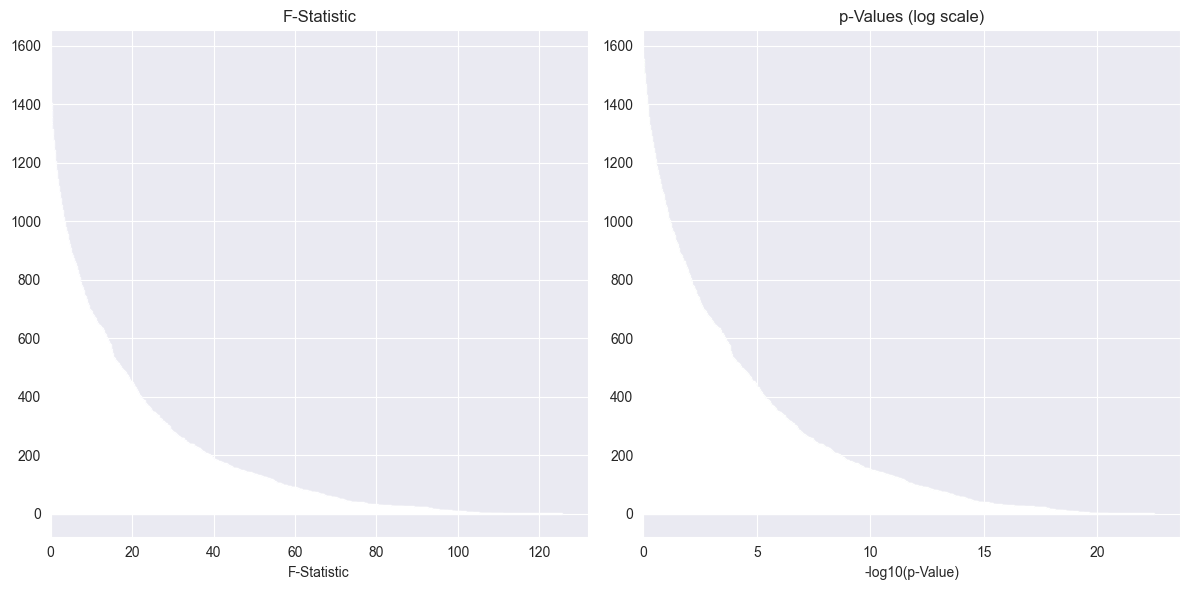

In [9]:
#pylidc data
pl_data = pd.read_csv("../Unsorted/Data files/CSV DATA FILES/backup_02_11_2023_afternoon/pylidcBackup.csv")
#pyradiomics data
pr_data = pd.read_csv("../Unsorted/Data files/CSV DATA FILES/backup_02_11_2023_afternoon/pyradiomicsBackup.csv")

#Combining pylidc and pyradiomics data
df = pd.concat([pl_data, pr_data], axis=1)
df.to_csv('ML pyradiomics/total_data.csv')

def cleaning_data(df):
    df = df.select_dtypes(include=[int, float])
    df = df.drop(df[df['Malignancy'] == 3].index)
    # Remove rows with NaN values in the "Malignancy" column
    df.dropna(subset=["Malignancy"], inplace=True)
    threshold = df.shape[1] - 10  # 10 or more NaN values to be dropped
    df = df.dropna(thresh=threshold)
    return df
def normalize_data(df):
    normalized_data = (df-df.min())/(df.max()-df.min())
    return normalized_data

def create_category_column(df):
    # Create a new "Category" column based on the "Malignancy" values
    df["Category"] = df["Malignancy"].apply(lambda x: 1 if x in [4, 5] else 0)
    # drop all categories which are not numerical
    df = df.select_dtypes(include=[int, float])
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    df = df.drop(columns=constant_columns)
    return df

def get_malignancy_column_dtype(df):
    # Check if the "Malignancy" column exists in the DataFrame
    if "Malignancy" in df.columns:
        malignancy_dtype = df["Malignancy"].dtype
        return malignancy_dtype
    else:
        return "Column 'Malignancy' not found in the DataFrame."

def f_selection_KBest(X,y,k=100):
    X_new = SelectKBest(f_classif, k=k).fit_transform(X, y)
    f_statistic, p_values = f_classif(X, y)
    return X_new, f_statistic, p_values

def f_selection_Percentile(X,y,p=10):
    X_new = SelectPercentile(f_classif, percentile=p).fit_transform(X,y)
    f_statistic, p_values = sklearn.feature_selection.f_classif(X,y)
    return X_new, f_statistic, p_values

def feature_select_plot(f_stat,p_val):
    # Create a DataFrame to store and sort the F-statistic and p-values
    results_df = pd.DataFrame({'F-Statistic': f_stat, 'p-Value': p_val})
    results_df = results_df.sort_values(by='p-Value', ascending=True)
    x_values = np.arange(0, len(f_stat), 1)

    # Plot the sorted F-statistic and p-values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(x_values, results_df['F-Statistic'], color='b')
    plt.xlabel('F-Statistic')
    plt.title('F-Statistic')
    plt.subplot(1, 2, 2)
    plt.barh(x_values, -np.log10(results_df['p-Value']), color='g')
    plt.xlabel('-log10(p-Value)')
    plt.title('p-Values (log scale)')
    plt.tight_layout()
    plt.show()

df = cleaning_data(df)
get_malignancy_column_dtype(df)
df = create_category_column(df)
df_norm = normalize_data(df)

# Creating the ML Dataset
X = df_norm.drop(columns=["Category","Malignancy"])  # X contains all columns except "Category"
y = df["Category"]  # y is the "Category" column
y_alt = df["Malignancy"]

X_new, f_statistic, p_values = f_selection_Percentile(X,y)
feature_select_plot(f_statistic,p_values)
X_new_df = pd.DataFrame(X_new)

X.to_csv("ML pyradiomics/X_all_cleaned.csv", index=False)
X_new_df.to_csv("ML pyradiomics/X.csv", index=False)
y.to_csv("ML pyradiomics/y.csv", index=False)
y_alt.to_csv("ML pyradiomics/y_alt.csv", index=False)

## 3. <a id='model1'>Model 1: Linear Support Vector Classifier</a>
Here we use the linear Support Vector Machine Classifier (LinearSVC) algorithm from the scikit package. It minimizes the loss function by updating model parameters in an iterative, stochastic way. We use this classifier is because it is particularly effective for large datasets, as it processes random subsets (mini-batches) of data, making it computationally efficient and suitable for online learning scenarios

In [11]:
X = pd.read_csv("ML pyradiomics/X.csv")
Y = pd.read_csv("ML pyradiomics/y.csv")
Y = Y.values.ravel()

In [22]:
#The model
def LSVC(X,Y,epochs, test_size):
    e = np.arange(0, epochs)
    acc_array = np.array([])
    for i in e:
        # divide training and test data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
        model = LinearSVC()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        acc_array = np.append(acc_array, accuracy)
        #print("Accuracy:", accuracy)


    #calculate average accurcy
    mean_acc = np.mean(acc_array)

    #make a plot
    plt.plot(e, acc_array)
    plt.rcParams['font.size'] = '11'
    #plt.figure(figsize=(8, 6), dpi=1000)
    plt.title('Accuracy per epoch, ' + "Dataset size: " + str(len(X)) + ' Nodules')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim(-0.05, 1.05)
    plt.axhline(mean_acc, color='red', linestyle='dashed', label='Mean accuracy')
    plt.show()
    return

#LSVC(X,Y,100, 0.2)

X_all = pd.read_csv("ML pyradiomics/X_all_cleaned.csv")
Y = pd.read_csv("ML pyradiomics/y_alt.csv")
Y = Y.values.ravel()
first_30 = np.arange(1,30,1)
last = np.arange(35,100,5)
feature_prop = first_30.append(last)
acc_array = []
test_size= 0.2
for p in feature_prop:
    X_new, f_statistic, p_values = f_selection_Percentile(X_all,Y,p)
    X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=test_size, random_state=1)
    model = LinearSVC()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    acc_array = np.append(acc_array, accuracy)
plt.plot(feature_prop,acc_array, label='Amout features used vs accuracy {}'.format(feature_prop))
plt.legend
plt.ylim(0,1)
plt.show()
    


AttributeError: 'numpy.ndarray' object has no attribute 'append'

## 4. <a id='model2'>Model 2: Stochastic Gradient Descent Regressor</a>

Here we use the Stochastic Gradient Descent Regressor (SGDR) algorithm from the scikit package. It minimizes the loss function by updating model parameters in an iterative, stochastic way. We use this algorithm is because it is particularly effective for large datasets, as it processes random subsets (mini-batches) of data, making it computationally efficient for a big dataset like the LIDC-IDRI dataset.


In [ ]:
X = pd.read_csv("Python scrips/ML pyradiomics/X.csv")
Y = pd.read_csv("Python scrips/ML pyradiomics/y_alt.csv")

In [ ]:
#The Model
def SGDR(X,Y,epochs, test_size):
    e = np.arange(0, epochs)
    acc_array = np.array([])
    for i in e:
        # divide training and test data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        predictions_rounded = [round(num) for num in predictions]
        accuracy = accuracy_score(y_test, predictions_rounded)
        acc_array = np.append(acc_array, accuracy)
        #print("Accuracy:", accuracy)

    #make a plot
    plt.plot(e, acc_array)
    plt.rcParams['font.size'] = '11'
    #plt.figure(figsize=(8, 6), dpi=1000)
    plt.title('Accuracy per epoch ' + "Dataset size: " + str(len(X)))
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    mean_acc = np.mean(acc_array)
    plt.axhline(mean_acc, color='red', linestyle='dashed', label='Mean accuracy')
    plt.show()
    return

X_all = pd.read_csv("Python scrips/ML pyradiomics/X_all_cleaned.csv")
Y = pd.read_csv("Python scrips/ML pyradiomics/y_alt.csv")
feature_prop = [3,5,8,10,15,20,25,30,35,40,45,50]
acc_array = []
for p in feature_prop:
    X_new, f_statistic, p_values = f_selection_Percentile(X_all,Y,p)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=1)
    model = LinearSVC()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    acc_array = np.append(acc_array, accuracy)
plt.plot(feature_prop,acc_array)
    

#SGDR(X,Y,100, 0.1)